In [1]:
import sys
sys.path.append("../")
import cv2 as cv
import pickle
import matplotlib.pyplot as plt
from evaluation import ImageData
from sky_filter import get_nonsky_mask
from img_utils import np_rgb_mask
from utils import Timer


from utils import * 

Loading weights for net_encoder
Loading weights for net_decoder


In [2]:
def adjust_affine_transform(components_indices, index, A):
    
    def add_third_row(column_vecs):
        return np.vstack((column_vecs, np.ones(column_vecs.shape[1])))


    coords = np.float32([[0.0, 0.0, 1.0], 
                        [components_indices.shape[1] + 1, 0.0, 1.0], 
                        [components_indices.shape[1] + 1, components_indices.shape[0] + 1, 1.0], 
                        [0.0, components_indices.shape[0] + 1, 1.0]])
    coords = np.transpose(coords)
    
#     coords = np.where(component_indices == index)
#     coords = np.array([coords[1], coords[0]])
#     coords = add_third_row(coords)

    new_coords = A @ coords
    new_coords = new_coords / new_coords[2, :]

    min_row = min(new_coords[1])
    max_row = max(new_coords[1])
    min_col = min(new_coords[0])
    max_col = max(new_coords[0])

    dst = np.float32([[min_col, min_row], [min_col, max_row - 1], [max_col - 1, max_row - 1], [max_col - 1, min_row]])
    dst = np.transpose(dst)
    dst = add_third_row(dst)

    translate_vec_new = (-np.min(dst[0]), -np.min(dst[1]))
    translate_matrix_new = np.array([
        [1, 0, translate_vec_new[0]],
        [0, 1, translate_vec_new[1]],
        [0, 0, 1],
    ])

    bounding_box = (math.ceil(max_col), math.ceil(max_row)) 
    
    A = translate_matrix_new @ A
    return A, bounding_box


def show_or_close(show):
    if show:
        plt.show(block=False)
    else:
        plt.close()


# TODO definitely clean this up!!
def create_plot_only_img(title, img_np, h_size_inches=10, transparent=False):

    fig = plt.figure(frameon=False, figsize=(h_size_inches, h_size_inches * img_np.shape[0] / img_np.shape[1]))

    if transparent:
        data_to_show = np.ones((*img_np.shape[:2], 4), dtype=int) * 255
        data_to_show[:, :, :3] = img_np
        mask = np_rgb_mask(data_to_show)
        # mask = np.logical_and(data_to_show[:, :, 0] == 0, data_to_show[:, :, 1] == 0)
        # mask = np.logical_and(mask, data_to_show[:, :, 2] == 0)
        data_to_show[mask, 3] = 0
    else:
        data_to_show = img_np

    fig.patch.set_facecolor('black')
    fig.patch.set_alpha(0.0)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    if title is not None:
        plt.title(title)
    #plt.imshow(img_np)
    plt.imshow(data_to_show)
    #cv.imwrite('OverBlack.png', dt_cp)
    return plt


In [3]:
def show_np(data, title=None):
    plt.figure(figsize=(9, 9))
    if title is not None:
        plt.title(title)
    plt.imshow(data)
    plt.show(block=False)

    
def prepare_sky_mask(img_data):
    non_sky_mask = get_nonsky_mask(img_data.img, *img_data.img.shape[:2])
    upsample = nn.Upsample(size=img_data.img.shape[:2], mode='nearest')
    t = torch.from_numpy(non_sky_mask)
    non_sky_mask = upsample(t[None, None].to(float))[0, 0].to(bool).numpy()
    return non_sky_mask

    

def read_img_data(img_path, img_data_path):

    for path in [img_path, img_data_path]:
        if not os.path.isfile(path):
            raise "path {} not found as file".format(path)

    img = cv.imread(img_path, None)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    with open(img_data_path, "rb") as f:
        img_serialized_data: ImageSerializedData = pickle.load(f)
    
    ret = ImageData.from_serialized_data(img=img,
                                             real_K=None,
                                             img_serialized_data=img_serialized_data)
    return ret


def non_valid_mask(cluster_indices, valid_component_dict):
    print("non_valid_mask cluster_indices.shape: {}".format(cluster_indices.shape))

    mask = np.zeros(cluster_indices.shape)
    for k in valid_component_dict.keys():
        mask = np.logical_or(mask, cluster_indices == k)
    ret = 1-mask
    print("non_valid_mask shape: {}".format(ret.shape))
    print("non_valid_mask sum: {}".format(ret.sum()))
    return ret


In [6]:
def custom_get_and_show_components(img_data,
                                   show=True,
                                   save=False,
                                   path=None,
                                   non_sky_mask=None):

    cluster_indices = img_data.components_indices
    valid_component_dict = img_data.valid_components_dict
    #normals = img_data.normals
    img = img_data.img
    

    get_and_show_components_inner(img_data,
                                  show, 
                                  save, 
                                  path, 
                                  filter=None, 
                                  non_sky_mask=non_sky_mask)

    
    if True:
        return
    
    for k in valid_component_dict.keys():
        get_and_show_components_inner(img_data,
                                      show, 
                                      save, 
                                      "{}_{}".format(path, k), 
                                      filter={k}, 
                                      non_sky_mask=non_sky_mask)
                                  

    magic = 1000000     
    mask = non_valid_mask(img_data.components_indices, valid_component_dict)
    old_ci = np.copy(img_data.components_indices)
    img_data.components_indices[mask == True] = magic
    #img_data.components_indices[mask] = magic
    valid_component_dict[magic] = magic
    
    get_and_show_components_inner(img_data,
                                  show, 
                                  save, 
                                  "{}_{}".format(path, "sky"), 
                                  filter={magic}, 
                                  non_sky_mask=1 - non_sky_mask)

    valid_component_dict.pop(magic, None)
    img_data.components_indices = old_ci
    
    

def get_and_show_components_inner(img_data,
                                  show=True, 
                                  save=False, 
                                  path=None, 
                                  filter=None, 
                                  non_sky_mask=None):

    cluster_indices = img_data.components_indices
    valid_component_dict = img_data.valid_components_dict
    img = img_data.img

    colors = [
        [255, 255, 0],
        [255, 0, 0],
        [0, 255, 0],
        [0, 0, 128], # changed from 0, 0, 255
        [255, 0, 255],
        [0, 255, 255],
        [128, 0, 0],
        [0, 128, 0],
        [0, 0, 128],
    ]

    if filter is not None:
        cluster_colors = np.zeros((cluster_indices.shape[0], cluster_indices.shape[1], 3), dtype=np.int32)

        if non_sky_mask is not None and filter.__contains__(-1):
            cluster_colors[non_sky_mask == 1] = [0, 0, 128]
        else:
            for i, c_index in enumerate(valid_component_dict.keys()):
                if filter is None or filter.__contains__(c_index):
                    cluster_colors[cluster_indices == c_index] = colors[i % 9]

        mask = 1 - np_rgb_mask(cluster_colors)
        
        print("shape1: {}".format(cluster_colors.shape))
        print("shape2: {}".format(mask.shape))
        
        indices = np.where(mask)
        min0 = indices[0].min()
        max0 = indices[0].max() + 1
        min1 = indices[1].min()
        max1 = indices[1].max() + 1
        print("mins - max: {}, {}, {}, {}".format(min0, max0, min1, max1))
        cropped = np.zeros((max0 - min0, max1 - min1, 3))
        cropped[:, :] = cluster_colors[min0:max0, min1:max1]
        print("shape3: {}".format(cropped.shape))
        cluster_colors = cropped
        print("cluster_colors.shape: {}".format(cluster_colors.shape))

    else:
        cluster_colors = np.copy(img)
        for i, c_index in enumerate(valid_component_dict.keys()):
            #if filter is None or filter.__contains__(c_index):
            for rgb_index in range(3):
                test = colors[i % 9][rgb_index] != 0
                print("Test: {}, index: {}".format(test, rgb_index))                    
                if colors[i % 9][rgb_index] != 0:
                    cluster_colors[cluster_indices == c_index, rgb_index] = colors[i % 9][rgb_index]
                else:
                    cluster_colors[cluster_indices == c_index, rgb_index] = img[cluster_indices == c_index, rgb_index]
                    print("sum: {}".format(cluster_colors[cluster_indices == c_index, rgb_index].sum()))

        if non_sky_mask is not None:
            cluster_colors[non_sky_mask == 0, :2] = 0
            cluster_colors[non_sky_mask == 0, 2] = 128 # cluster_colors[non_sky_mask == 0, 2] / 2

    if show or save:
        
        height = 5 if filter is None else 2
        plt_v = create_plot_only_img(None, cluster_colors, height, transparent=(filter is not None))

        if save:
            print("path: {}".format(path))
            plt.savefig(path, dpi=24, transparent=True, facecolor=(0.0, 0.0, 0.0, 0.0))
        show_or_close(show)

    return cluster_colors
    


Time elapsed from start: 0.0347., 
Global time elapsed from start: 184.0140., 
Statistics: 
read img data called 1 times and it took 0.0334 secs. on average
Test: True, index: 0
Test: True, index: 1
Test: False, index: 2
sum: 34293577
Test: True, index: 0
Test: False, index: 1
sum: 3609325
Test: False, index: 2
sum: 2863916
Test: False, index: 0
sum: 16841811
Test: True, index: 1
Test: False, index: 2
sum: 10690149
path: ./work/frame_out


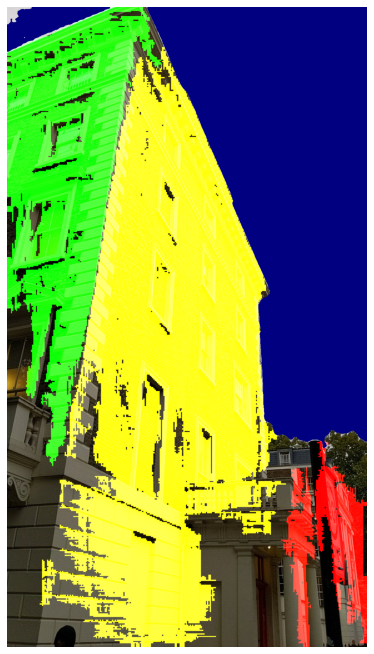

shape1: (1920, 1080, 3)
shape2: (1920, 1080)
mins - max: 120, 1920, 98, 837
shape3: (1800, 739, 3)
cluster_colors.shape: (1800, 739, 3)
path: ./work/frame_out_11


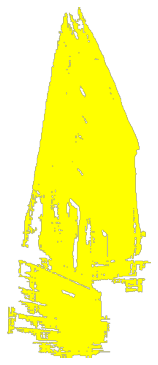

shape1: (1920, 1080, 3)
shape2: (1920, 1080)
mins - max: 1302, 1920, 822, 1080
shape3: (618, 258, 3)
cluster_colors.shape: (618, 258, 3)
path: ./work/frame_out_88


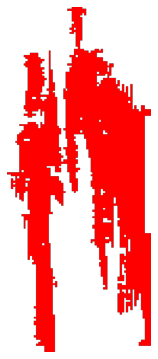

shape1: (1920, 1080, 3)
shape2: (1920, 1080)
mins - max: 0, 1377, 0, 465
shape3: (1377, 465, 3)
cluster_colors.shape: (1377, 465, 3)
path: ./work/frame_out_89


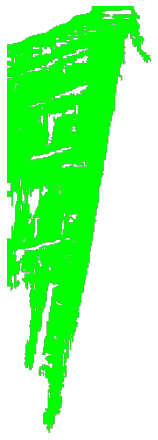

non_valid_mask cluster_indices.shape: (1920, 1080)
non_valid_mask shape: (1920, 1080)
non_valid_mask sum: 1019517
shape1: (1920, 1080, 3)
shape2: (1920, 1080)
mins - max: 0, 1920, 0, 1080
shape3: (1920, 1080, 3)
cluster_colors.shape: (1920, 1080, 3)
path: ./work/frame_out_sky


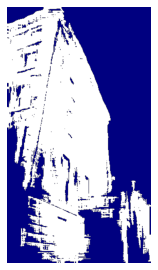

P: [[0.5 0.  0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]], bb:(541, 1921)
Test: True, index: 0
Test: True, index: 1
Test: False, index: 2
sum: 17163957
Test: True, index: 0
Test: False, index: 1
sum: 1800589
Test: False, index: 2
sum: 1431488
Test: False, index: 0
sum: 8431605
Test: True, index: 1
Test: False, index: 2
sum: 5356020
path: ./work/frame_out_i


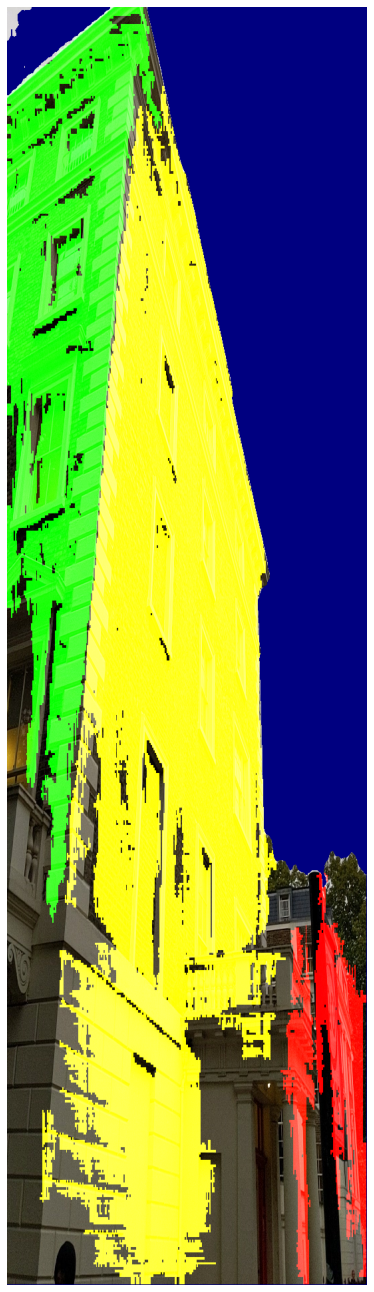

shape1: (1921, 541, 3)
shape2: (1921, 541)
mins - max: 120, 1920, 49, 419
shape3: (1800, 370, 3)
cluster_colors.shape: (1800, 370, 3)
path: ./work/frame_out_i_11


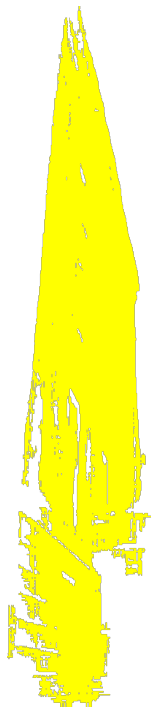

shape1: (1921, 541, 3)
shape2: (1921, 541)
mins - max: 1302, 1920, 411, 540
shape3: (618, 129, 3)
cluster_colors.shape: (618, 129, 3)
path: ./work/frame_out_i_88


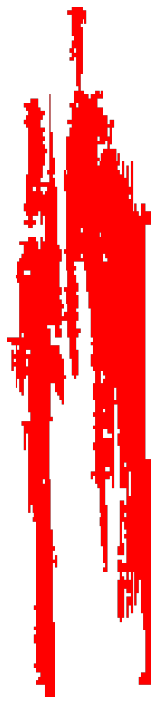

shape1: (1921, 541, 3)
shape2: (1921, 541)
mins - max: 0, 1377, 0, 233
shape3: (1377, 233, 3)
cluster_colors.shape: (1377, 233, 3)
path: ./work/frame_out_i_89


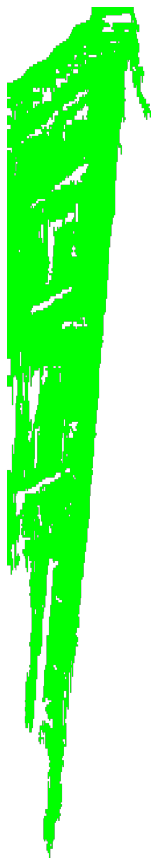

non_valid_mask cluster_indices.shape: (1921, 541)
non_valid_mask shape: (1921, 541)
non_valid_mask sum: 512225
shape1: (1921, 541, 3)
shape2: (1921, 541)
mins - max: 0, 1921, 0, 541
shape3: (1921, 541, 3)
cluster_colors.shape: (1921, 541, 3)
path: ./work/frame_out_i_sky


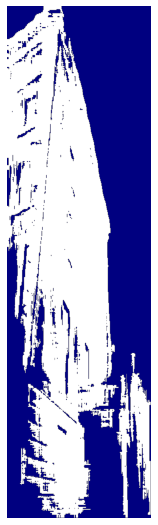

In [9]:
paths = ["../original_dataset/scene1/images/frame_0000000475_1.jpg",
                          "../work/pipeline_scene1_333/imgs/frame_0000000475_1_img_data.pkl"]

Timer.start()
Timer.start_check_point("read img data")

img_data = read_img_data(*paths)
#show_np(img_data.img, title=img_path.split("/")[-1])

Timer.end_check_point("read img data")

Timer.start_check_point("read sky mask")

sky_path =  "../work/pipeline_scene1_333/imgs/frame_0000000475_1_sky.pkl"
# non_sky_mask = prepare_sky_mask(img_data)
# show_np(non_sky_mask, title="sky")
# with open(sky_path, "wb") as f:
#     pickle.dump(non_sky_mask, f)

with open(sky_path, "rb") as f:
    non_sky_mask = pickle.load(f)
#show_np(non_sky_mask, title="sky")


Timer.start_check_point("read sky mask")
Timer.log_stats()
out = "frame_out"

if img_data.img is None:
    raise "img_data.img is None"

#print("img: {}".format(img_data.img))
    
custom_get_and_show_components(img_data,
                               show=True,
                               save=True,
                               path="./work/frame_out",
                               non_sky_mask=non_sky_mask)

#print("img: {}".format(img_data.img))


As = np.array([[[0.5, 0.0, 0.0],
             [0.0, 1.0, 0.0],
             [0.0, 0.0, 1.0]
            ]])


for i, A in enumerate(As):
    
    A, bb = adjust_affine_transform(img_data.components_indices, 10001, A)
    print("P: {}, bb:{}".format(A, bb))    

    old_ci = np.copy(img_data.components_indices)
    old_img = np.copy(img_data.img)
    old_sky = np.copy(non_sky_mask)

    img_data.components_indices = np.int32(cv.warpPerspective(np.float32(img_data.components_indices), A, bb))
    img_data.img = np.int32(cv.warpPerspective(np.float32(img_data.img), A, bb))
    non_sky_mask = np.int32(cv.warpPerspective(np.float32(non_sky_mask), A, bb))


    custom_get_and_show_components(img_data,
                               show=True,
                               save=True,
                               path="./work/frame_out_i",
                               non_sky_mask=non_sky_mask)

    img_data.components_indices = old_ci
    img_data.img = old_img
    non_sky_mask = old_sky
